In [1]:
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from ignite.handlers import create_lr_scheduler_with_warmup

from score_models.trainer import trainer
from score_models.models.mlp import MLPScoreModel
from score_models.train_steps.ddpm_train_step import TrainStepDDPM
from score_models.utils.data import guassian_mixture
from score_models.utils.noise import get_betas
from score_models.sampling import ddpm_sampling

In [2]:
# load dataset
dataset = guassian_mixture(N=10_000)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [3]:
device = "cuda"
input_size = 2
hidden_size = 32
T = 1000
lr = 1e-4
weight_decay = 1e-4

# define score model and optimizer
score_model = MLPScoreModel(input_size=input_size, hidden_size=hidden_size, T=T).to(device)
optimizer = optim.AdamW(score_model.parameters(), lr=lr, weight_decay=weight_decay)


# Create a chained scheduler
num_steps = 100_000
warmup_steps = int(0.1 * num_steps)

scheduler = create_lr_scheduler_with_warmup(
    CosineAnnealingLR(optimizer, T_max=num_steps - warmup_steps),
    warmup_start_value=0.0,
    warmup_end_value=lr,
    warmup_duration=warmup_steps,
)

# define train step (i.e., criterion)
beta_min, beta_max = 1e-4, 2e-2
betas = get_betas(beta_min=beta_min, beta_max=beta_max, T=T)
train_step = TrainStepDDPM(score_model=score_model, alphas_bar=betas["alphas_bar"])


In [4]:
score_model = trainer(
    train_step=train_step,
    model=score_model,
    train_loader=dataloader,
    optimizer=optimizer,
    device=device,
    num_steps=num_steps,
    log_every=10_000,
    save_every=50_000,
)

  0%|          | 31/100000 [00:00<22:31, 73.98it/s]  

Step 1, Loss: 1.8718


 10%|█         | 10045/100000 [00:34<05:08, 291.56it/s]

Step 10000, Loss: 1.1633


 20%|██        | 20034/100000 [01:05<04:09, 320.14it/s]

Step 20000, Loss: 1.0420


 30%|███       | 30037/100000 [01:35<03:21, 347.11it/s]

Step 30000, Loss: 0.9075


 40%|████      | 40039/100000 [02:07<03:22, 295.49it/s]

Step 40000, Loss: 0.8226


 50%|█████     | 50035/100000 [02:41<02:58, 280.63it/s]

Step 50000, Loss: 0.7986


 60%|██████    | 60031/100000 [03:14<02:08, 309.98it/s]

Step 60000, Loss: 0.7892


 70%|███████   | 70056/100000 [03:46<01:39, 300.22it/s]

Step 70000, Loss: 0.7864


 80%|████████  | 80052/100000 [04:17<01:03, 314.17it/s]

Step 80000, Loss: 0.7539


 90%|█████████ | 90043/100000 [04:49<00:31, 318.88it/s]

Step 90000, Loss: 0.7772


100%|██████████| 100000/100000 [05:20<00:00, 311.93it/s]

Step 100000, Loss: 0.7547


In [5]:
x = torch.randn(500, 2).to(device)
samples = ddpm_sampling(
    x=x,
    score_model=score_model,
    alphas=betas["alphas"],
    alphas_bar=betas["alphas_bar"],
    sigmas=betas["sigmas"],
    T=T
).cpu().numpy()

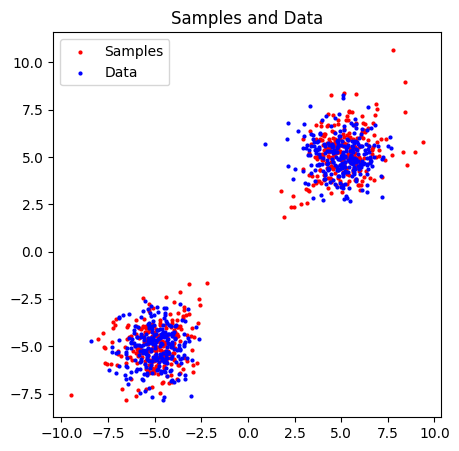

In [6]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
ax.scatter(samples[:, 0], samples[:, 1], color='red', s=4, label='Samples')
ax.scatter(dataset[:500][:, 0], dataset[:500][:, 1], color='blue', s=4, label='Data')
ax.set_title('Samples and Data')
plt.legend();